In [1]:
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# Посмотрим на данные
df = pd.read_csv('german_credit_data.csv')
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [3]:
len(df)

1000

In [4]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [6]:
# Обработаем пропущенные значения
df['Saving accounts'] = df['Saving accounts'].fillna('unknown')
df['Checking account'] = df['Checking account'].fillna('unknown')

# Категориальные признаки
categorical_columns = ['Sex', 'Housing', 'Checking account', 'Purpose']
order = [['unknown', 'little', 'moderate', 'quite rich', 'rich']]

# Инициализация OneHotEncoder и OrdinalEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
oe = OrdinalEncoder(categories=order)

# Обучим и применим OE
df['Saving accounts'] = oe.fit_transform(df[['Saving accounts']])

# Обучим и применим OHE
encoded_data = ohe.fit_transform(df[categorical_columns]).toarray()

# Преобразуем закодированные данные в датасет
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(categorical_columns))

# Объединим с исходным датасетом
df = pd.concat([df, encoded_df], axis=1).drop(categorical_columns, axis=1)
df.head()

,Age,Job,Saving accounts,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,...,Checking account_rich,Checking account_unknown,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,2,0.0,1169,6,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,22,2,1.0,5951,48,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,49,1,1.0,2096,12,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,45,2,1.0,7882,42,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,53,2,1.0,4870,24,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Сохраним эндкодеры
joblib.dump(ohe, 'one_hot_encoder.joblib')
joblib.dump(oe, 'ordinal_encoder.joblib')

['ordinal_encoder.joblib']

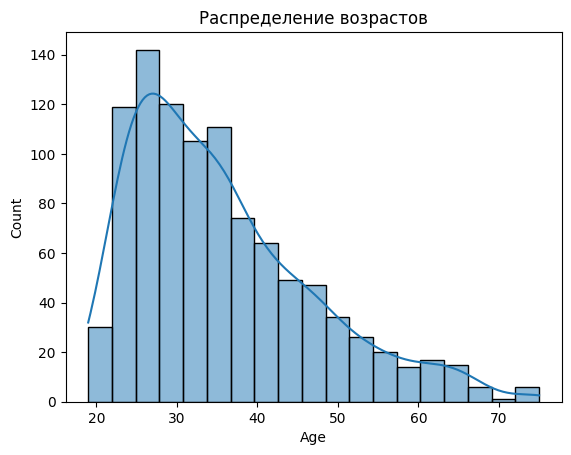

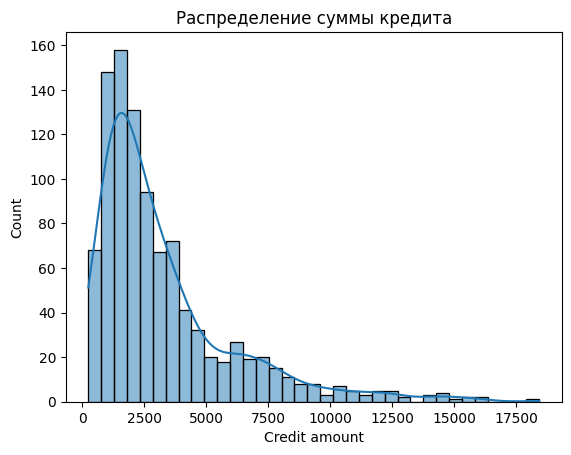

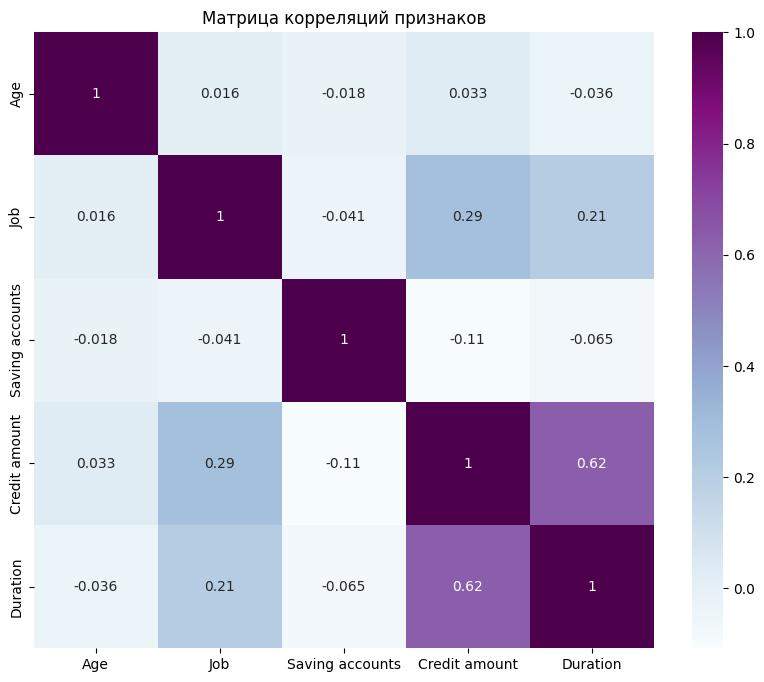

In [7]:
# Все бесконечные значения преобразуем в NaN перед анализом
df = df.replace([np.inf, -np.inf], np.nan)

# Распределение возрастов
sns.histplot(df['Age'], kde=True)
plt.title('Распределение возрастов')
plt.show()

# Распределение суммы кредита
sns.histplot(df['Credit amount'], kde=True)
plt.title('Распределение суммы кредита')
plt.show()

#Матрица корреляций признаков
df_corr = df.drop(columns = ohe.get_feature_names_out(categorical_columns))
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr(), annot=True, cmap='BuPu')
plt.title('Матрица корреляций признаков')
plt.show()

In [8]:
# Разделим признаки и таргет
X = df.drop(columns=['Credit amount'])
y = df['Credit amount'] > df['Credit amount'].median()  # Бинарная классификация High/Low Credit Amount

# Разделим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизируем признаки
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Сохраним StandardScaler
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [10]:
#Подбор гиперпараметров
estimators = [10, 50, 100, 300, 400, 500, 600]
min_samples_leaf = list(np.arange(1, 20, 5))
max_depth = list(np.arange(1, 5, 1))

grid_values = {'n_estimators': estimators, 'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth}

clf = GridSearchCV(RandomForestClassifier(), grid_values, scoring = 'roc_auc', cv = 5)
clf.fit(X_train, y_train)

best_n_estimators_value = clf.best_params_['n_estimators']
best_min_samples_leaf = clf.best_params_['min_samples_leaf']
best_max_depth = clf.best_params_['max_depth']
best_score = clf.best_score_

print('Оптимальное количество деревьев', best_n_estimators_value)
print('Оптимальное количество листьев', best_min_samples_leaf)
print('Оптимальная глубина', best_max_depth)
print('AUC-ROC', best_score)

Оптимальное количество деревьев 300
Оптимальное количество листьев 6
Оптимальная глубина 4
AUC-ROC 0.8247955311966837


In [11]:
# Обучаем лучшую модель
rand_clf = RandomForestClassifier(n_estimators = best_n_estimators_value, max_depth = best_max_depth, min_samples_leaf = best_min_samples_leaf, random_state = 42)
rand_clf.fit(X_train, y_train)

y_pred = rand_clf.predict(X_test)

In [12]:
#Оценка точности
roc_auc = roc_auc_score(y_test, y_pred)
print(f'roc_auc: {roc_auc}')

roc_auc: 0.7331393014853472


In [13]:
# Смотрим на важность признаков
importances = rand_clf.feature_importances_
features = pd.DataFrame({"feature": X.columns, 'importance': importances})
features.sort_values(by = 'importance', ascending = False)

,feature,importance
3,Duration,0.547116
1,Job,0.122122
18,Purpose_radio/TV,0.054286
0,Age,0.048582
6,Housing_free,0.023445
2,Saving accounts,0.022283
4,Sex_female,0.020975
10,Checking account_moderate,0.020155
14,Purpose_car,0.019502
5,Sex_male,0.019489


In [ ]:
# Сохраняем обученную модель
joblib.dump(rand_clf, 'credit_risk_random_forest_model.joblib')

['credit_risk_random_forest_model.joblib']

In [14]:
# Результаты
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print('-----------------')
print("Confusion Matrix:")
print(conf_matrix)
print('-----------------')
print("Classification Report:")
print(class_report)

Accuracy: 0.73
-----------------
Confusion Matrix:
[[81 25]
 [28 66]]
-----------------
Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.76      0.75       106
        True       0.73      0.70      0.71        94

    accuracy                           0.73       200
   macro avg       0.73      0.73      0.73       200
weighted avg       0.73      0.73      0.73       200



In [17]:
#Подбор гиперпараметров
estimators = [10, 50, 100, 300, 400, 500, 600]
min_samples_leaf = list(np.arange(1, 20, 5))
max_depth = list(np.arange(1, 10, 3))

grid_values = {'n_estimators': estimators, 'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth}

clf = GridSearchCV(GradientBoostingClassifier(), grid_values, scoring = 'roc_auc', cv = 5)
clf.fit(X_train, y_train)

best_n_estimators_value_boost = clf.best_params_['n_estimators']
best_min_samples_leaf_boost = clf.best_params_['min_samples_leaf']
best_max_depth_boost = clf.best_params_['max_depth']
best_score_boost = clf.best_score_

print('Оптимальное количество деревьев', best_n_estimators_value_boost)
print('Оптимальное количество листьев', best_min_samples_leaf_boost)
print('Оптимальная глубина', best_max_depth_boost)
print('AUC-ROC', best_score_boost)

Оптимальное количество деревьев 100
Оптимальное количество листьев 6
Оптимальная глубина 1
AUC-ROC 0.8283911915176709


In [19]:
gb_clf = GradientBoostingClassifier(n_estimators=best_n_estimators_value_boost, learning_rate=0.1, min_samples_leaf = best_min_samples_leaf_boost, max_depth=best_max_depth_boost, random_state=42)

# Обучаем лучшую модель
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)

# Оценка точности
roc_auc = roc_auc_score(y_test, y_pred)
print(f'roc_auc: {roc_auc}')

roc_auc: 0.7649538338016861


In [22]:
# Результаты
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print('-----------------')
print("Confusion Matrix:")
print(conf_matrix)
print('-----------------')
print("Classification Report:")
print(class_report)

Accuracy: 0.77
-----------------
Confusion Matrix:
[[90 16]
 [30 64]]
-----------------
Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.85      0.80       106
        True       0.80      0.68      0.74        94

    accuracy                           0.77       200
   macro avg       0.78      0.76      0.77       200
weighted avg       0.77      0.77      0.77       200



In [20]:
# Сохраняем лучшую модель
joblib.dump(gb_clf, 'best_credit_risk_model.joblib')

['best_credit_risk_model.joblib']

In [21]:
# Добавим предсказания в df
df_test = df.iloc[y_test.index].copy()
df_test['Prediction'] = y_pred
df_test['Actual'] = y_test.values

# True Negatives: (low risk)
true_negatives = df_test[(df_test['Actual'] == 0) & (df_test['Prediction'] == 0)]

# True Positives: (high risk)
true_positives = df_test[(df_test['Actual'] == 1) & (df_test['Prediction'] == 1)]

# Выведем True Negatives
print("True Negatives:")
display(true_negatives)

# Выведем True Positives
print("\nTrue Positives:")
display(true_positives)

True Negatives:


,Age,Job,Saving accounts,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,...,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Prediction,Actual
660,23,2,1.0,1297,12,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,False
626,41,2,1.0,2116,6,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,False
513,20,2,1.0,585,12,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,False
811,28,1,1.0,484,6,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,False
636,28,2,3.0,1376,24,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,36,2,0.0,846,7,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,False
526,31,2,2.0,1532,15,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False,False
137,66,1,3.0,766,12,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,False
365,36,2,1.0,1542,12,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False



True Positives:


,Age,Job,Saving accounts,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,...,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Prediction,Actual
740,32,2,2.0,2325,24,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True
411,35,3,1.0,7253,33,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True
136,27,2,4.0,8613,27,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True
76,34,2,1.0,3965,42,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True,True
973,36,2,1.0,7297,60,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,26,3,3.0,3235,24,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True,True
332,24,3,2.0,7408,60,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True
208,21,1,1.0,6568,24,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True
613,22,2,1.0,3632,24,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True
